# Goal
Create a notebook that segments cat faces using SegNet

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import theano
import sys

from skimage.io import imread
from matplotlib import pyplot as plt

import os
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN, device=gpu0, floatX=float32, optimizer=fast_compile'

from keras import models
from keras.optimizers import SGD

# Load Data
Data comes from mom and I labeling, and google scraping using bin/scrape_google_images.py

![Cuter than a cat](https://s-media-cache-ak0.pinimg.com/originals/ea/7a/c1/ea7ac155ff8f9b19aa879ab656402b6a.jpg)

### Training: 
Pictures/train

### Testing:
Pictures/test

# Define Network

SegNet to start with: https://github.com/imlab-uiip/keras-segnet

In [3]:
path = 'Pictures/'
img_w = 256
img_h = 256
n_labels = 2

n_train = 493
n_test = 49

WITH_AUGMENTATION = 1
TRAIN_ENABLED = 1

In [4]:
from keras import models
from keras.layers.core import Activation, Reshape, Permute
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras import backend as K

import json

img_w = 256
img_h = 256
n_labels = 2


if K.image_data_format() == 'channels_first':
    input_shape = (3, img_w, img_h)
else:
    input_shape = (img_w, img_h, 3)
    
kernel = 3

encoding_layers = [
    Conv2D(64, kernel, padding='same', input_shape=input_shape),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(128, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(256, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
]

autoencoder = models.Sequential()
autoencoder.encoding_layers = encoding_layers

for l in autoencoder.encoding_layers:
    autoencoder.add(l)

decoding_layers = [
    UpSampling2D(),
    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(256, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(128, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(64, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(n_labels, 1, padding='valid'),
    BatchNormalization(),
]
autoencoder.decoding_layers = decoding_layers
for l in autoencoder.decoding_layers:
    autoencoder.add(l)

In [4]:
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
activation_2 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
__________

In [5]:
autoencoder.add(Reshape((n_labels, img_h * img_w)))
autoencoder.add(Permute((2, 1)))
autoencoder.add(Activation('softmax'))

with open('model_5l.json', 'w') as outfile:
    outfile.write(json.dumps(json.loads(autoencoder.to_json()), indent=2))
print('Compiled: OK')

Compiled: OK


In [6]:
from PIL import Image

def prep_data(path, mode):
    assert mode in {'test', 'train'}, \
        'mode should be either \'test\' or \'train\''
    data = []
    label = []
    df = pd.read_csv(path + mode + '.csv')
    n = n_train if mode == 'train' else n_test
    count = 0
    for i, item in df.iterrows():
        if i >= n:
            print("broken")
            break
        img, gt = [imread(item[0])], np.clip(imread(item[1]), 0, 1)
        data.append(img)
        label.append(label_map(gt))
        sys.stdout.write('\r')
        sys.stdout.write(mode + ": [%-20s] %d%%" % ('=' * int(20. * (i + 1) / n - 1) + '>',
                                                    int(100. * (i + 1) / n)))
        sys.stdout.flush()
        count = count + 1
    sys.stdout.write('\r')
    sys.stdout.flush()
    
    data = np.array(data)
    data = data.reshape((data.shape[0] * data.shape[1], data.shape[2], data.shape[3], data.shape[4]))
    print("There are counts: ", str(count))
    label = np.array(label).reshape((n, img_h * img_w, n_labels))

    print(mode + ': OK')
    print('\tshapes: {}, {}'.format(data.shape, label.shape))
    print('\ttypes:  {}, {}'.format(data.dtype, label.dtype))
    print('\tmemory: {}, {} MB'.format(data.nbytes / 1048576, label.nbytes / 1048576))

    return data, label

In [7]:
def label_map(labels):
    label_map = np.zeros([img_h, img_w, n_labels])    
    for r in range(img_h):
        for c in range(img_w):
            label_map[r, c, labels[r][c]] = 1
    return label_map

In [8]:
def orig_filename_from_mask_filename(mask_filename):
    file_name_without_trailing_mask_keyword = mask_filename.split(".mask.0_new")[0]
    file_name = file_name_without_trailing_mask_keyword + "_new.jpg"
    print(mask_filename + " to " + file_name)
    return file_name

def separate_images_and_masks_into_subdirectories(path):
    if os.path.exists(os.path.join(path, 'images')) or os.path.exists(os.path.join(path, 'masks')):
        return
    else:
        os.makedirs(os.path.join(path, 'images'))
        os.makedirs(os.path.join(path, 'masks'))
        for file_name in os.listdir(path):
          from_file = os.path.join(path, file_name)
          if file_name.endswith(".mask.0_new.jpg"):
            to_file = os.path.join(path, "masks", orig_filename_from_mask_filename(file_name))
            try:
              os.rename(from_file, to_file)
              print("Moving Mask: {0}".format(from_file))
            except Exception:
              print("Error saving mask: {0}".format(from_file))
          elif file_name.endswith("jpg"):
            to_file = os.path.join(path, "images", file_name)
            try:
              os.rename(from_file, to_file)
              print("Moving Image: {0}".format(from_file))
            except Exception:
              print("Error saving mask: {0}".format(from_file))

In [9]:
def reduce_dim3_to_dim1(masks):
    label_map = np.zeros([img_h, img_w, n_labels])    
    for r in range(img_h):
        for c in range(img_w):
            if (masks[r][c][0] != 0 or masks[r][c][1] != 0 or masks[r][c][2] != 0):
                label_map[r, c, 1] = 1
            else:
                label_map[r, c, 0] = 1
    return label_map

In [54]:
from keras.callbacks import ModelCheckpoint
from path import Path
from keras.preprocessing.image import ImageDataGenerator
batch_size = 18
output_shape = (256, 256)
nb_epoch = 50

if WITH_AUGMENTATION:
  seed = 1
  dest_dir = Path('../Pictures/train_aug')

  separate_images_and_masks_into_subdirectories("../Pictures/train_aug") 
  
  # make sure image match
  images=sorted(dest_dir.glob('images/*.jpg'))
  masks=sorted(dest_dir.glob('masks/*.jpg'))
  assert len(dest_dir.glob('images/*.jpg'))==len(dest_dir.glob('masks/*.jpg')), 'should be same number of pngs'
  for i,[image,mask] in enumerate(zip(images,masks)):
    assert image.basename()==mask.basename(),'i=%s %s!=%s'%(i,image.basename(),mask.basename())
    
  data_gen_args=dict(
                rotation_range=10.,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=np.deg2rad(10),
                zoom_range=0.1,
                channel_shift_range=0.01,
                horizontal_flip=True,
                vertical_flip=True,
  )
  datagen1 = ImageDataGenerator(**data_gen_args)
  datagen2 = ImageDataGenerator(**data_gen_args)
#   datagen1.fit(images, augment=True, seed=seed)
#   datagen2.fit(masks, augment=True, seed=seed)

  image_gen=datagen1.flow_from_directory(dest_dir, 
                                  class_mode=None,
                                  classes=['images'], 
                                  batch_size=batch_size, 
                                  seed=seed,
                                  target_size=output_shape,
                                  save_to_dir='../Pictures/augmented_images', save_prefix='cat', save_format='jpg' 
                                 )
  mask_gen=datagen2.flow_from_directory(dest_dir, 
                                  class_mode=None, 
                                  classes=['masks'], 
                                  batch_size=batch_size, 
                                  seed=seed,
                                  target_size=output_shape,
                                  save_to_dir='../Pictures/augmented_masks', save_prefix='cat', save_format='jpg'
                                 )

#   train_generator = zip(image_gen, mask_gen)

  def dual_gen(image_gen,mask_gen):
    for images,masks in zip(image_gen,mask_gen):
      i = Image.fromarray(images[0], 'RGB')
      i.show()
      return
      new_masks = []
      for mask in masks:
        mask = reduce_dim3_to_dim1(mask)
        mask_img = Image.fromarray(mask, 'RGB')
        new_masks.append(mask)
      new_masks = np.array(new_masks).reshape(masks.shape[0], masks.shape[1]*masks.shape[2], n_labels)
      yield images,new_masks
    
  train_gen=dual_gen(image_gen,mask_gen)
  train_data, train_label=next(train_gen)
    
  train_sample = Image.fromarray(train_data[0], 'RGB')
  train_sample.show()
    
  label_sample = Image.fromarray(train_label[0], 'RGB')
  label_sample.show()
else:
  train_data, train_label = prep_data('../Pictures/', 'train')
  test_data, test_label = prep_data('../Pictures/', 'test')

autoencoder.compile(optimizer=SGD(lr = 0.1, decay = 1e-6, momentum = 0.9, nesterov = False),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
print(train_data.shape)
print(train_label.shape)

Found 494 images belonging to 1 classes.
Found 494 images belonging to 1 classes.


StopIteration: 

In [28]:

if TRAIN_ENABLED:
  checkpoint = ModelCheckpoint('.', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  if not WITH_AUGMENTATION:
    history = autoencoder.fit(train_data, train_label, batch_size=batch_size, epochs=nb_epoch, verbose=1,  callbacks=[checkpoint])
  else:
    history = autoencoder.fit_generator(train_generator, 
                               samples_per_epoch=batch_size, 
                               nb_epoch=nb_epoch, 
                               verbose=1, 
                               callbacks=[checkpoint])

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: The semantics of the Keras 2 argument  `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Update your method calls accordingly.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<zip objec..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=18, epochs=50)`


Epoch 1/50


ValueError: Error when checking target: expected activation_26 to have 3 dimensions, but got array with shape (18, 256, 256, 3)

In [12]:
autoencoder.save_weights('model_5l_weight_ep50_384_auto_dataaug.hdf5')

In [13]:
autoencoder.load_weights('model_5l_weight_ep50_384_auto_dataaug.hdf5')

from keras.utils.vis_utils import plot_model

plot_model(autoencoder, to_file='model_384_auto_dataaug.png', show_shapes=True)

In [18]:
# test gen
data_gen_args=dict(
                fill_mode='constant'
)

dest_dir_test = Path('../Pictures/test_aug')
separate_images_and_masks_into_subdirectories("../Pictures/test_aug") 

datagen_test1 = ImageDataGenerator(**data_gen_args)
datagen_test2 = ImageDataGenerator(**data_gen_args)

image_gen_test=datagen_test1.flow_from_directory(dest_dir_test, 
                                  class_mode=None, 
                                  classes=['images'], 
                                  batch_size=batch_size, 
                                  seed=seed,
                                  target_size=output_shape,
                                  shuffle=False
                                 )
mask_gen_test=datagen_test2.flow_from_directory(dest_dir_test, 
                                  class_mode=None, 
                                  classes=['masks'], 
                                  batch_size=batch_size, 
                                  seed=seed,
                                  target_size=output_shape,
                                  shuffle=False
                                 )

# join the generators
def dual_gen(image_gen,mask_gen):
    for images,masks in zip(image_gen_test,mask_gen_test):
      new_masks = []
      for mask in masks:
        mask = reduce_dim3_to_dim1(mask)
        new_masks.append(mask)
      new_masks = np.array(new_masks).reshape(masks.shape[0], masks.shape[1]*masks.shape[2], n_labels)
      yield images,new_masks

test_gen=dual_gen(image_gen_test,mask_gen_test)

test_data, test_label=next(test_gen)
test_data.shape, test_label.shape

Found 50 images belonging to 1 classes.
Found 50 images belonging to 1 classes.


((18, 256, 256, 3), (18, 65536, 2))

In [50]:
n = [1, 2, 3]
m = [2, 4, 8]
for a, b in zip(n, m):
    print(a)
    print(b)

1
2
2
4
3
8


In [19]:
autoencoder.compile(optimizer=SGD(lr = 0.1, decay = 1e-6, momentum = 0.9, nesterov = False),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
score = autoencoder.evaluate(test_data, test_label, verbose=0)

print('Test score:',  score[0])
print('Test accuracy:', score[1])

Test score: 1.67715191841
Test accuracy: 0.243397176266


In [21]:
output = autoencoder.predict_proba(test_data, verbose=0)
output = output.reshape((output.shape[0], img_h, img_w, n_labels))

In [ ]:
print(output.shape)

In [ ]:
print(output)

In [22]:
from skimage import data, color, io, img_as_float

def plot_results(output):
    gt = []
    df = pd.read_csv('../Pictures/test.csv')
    for i, item in df.iterrows():
        gt.append(np.clip(imread(item[1]), 0, 1))

    plt.figure(figsize=(6, n_test*2))
    for i, item in df.iterrows():
        plt.subplot(n_test, 4, 4 * i + 1)
        plt.title('Ground Truth')
        plt.axis('off')
        gt = imread(item[1])
        plt.imshow(np.clip(gt, 0, 1))
        
        plt.subplot(n_test, 4, 4 * i + 2)
        plt.title('Prediction')
        plt.axis('off')
        labeled = np.argmax(output[i], axis=-1)
        plt.imshow(labeled)

        plt.subplot(n_test, 4, 4 * i + 3)
        plt.title('Heat map')
        plt.axis('off')
        plt.imshow(output[i][:, :, 1])

        plt.subplot(n_test, 4, 4 * i + 4)
        plt.title('Comparison')
        plt.axis('off')
#         rgb = np.empty((img_h, img_w, 3))
#         rgb[:, :, 0] = labeled
        img = imread(item[0])
        img_hsv = color.rgb2hsv(img)
        img_hsv[..., 1] = labeled
#         img_hsv[..., 1] = gt
#         rgb[:, :, 1] = imread(item[0])
#         rgb[:, :, 2] = gt
        img = color.hsv2rgb(img_hsv)
        plt.imshow(img)

    plt.savefig('result_aug.png')
    plt.show()

IndexError: index 18 is out of bounds for axis 0 with size 18

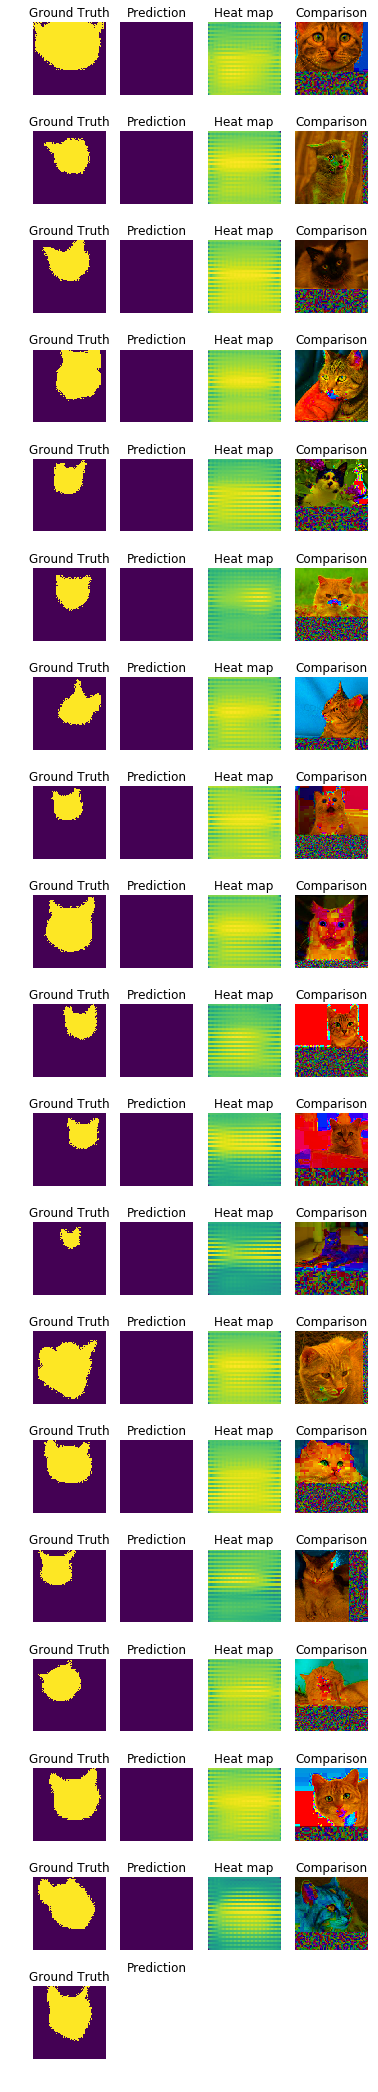

In [23]:
plot_results(output)